<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Localisation-Network" data-toc-modified-id="Localisation-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Localisation Network</a></span></li><li><span><a href="#Regressor-for-transformation-parameters" data-toc-modified-id="Regressor-for-transformation-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regressor for transformation parameters</a></span></li><li><span><a href="#Parameterised-Sampling-Grid" data-toc-modified-id="Parameterised-Sampling-Grid-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameterised Sampling Grid</a></span></li><li><span><a href="#Spatial-Transformer" data-toc-modified-id="Spatial-Transformer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Spatial Transformer</a></span></li></ul></div>

# Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from layers.localisation_net import LocalisationNet
from layers.affine_dense import AffineDense
from layers.sampling_grid import SamplingGrid
from layers.bilinear_sampler import BilinearSampler
from layers.spatial_transformer import SpatialTransformer

In [2]:
IMG_SIZE = 28

# Localisation Network

In [3]:
loc_net_layer = LocalisationNet()

In [4]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = loc_net_layer.conv_1(input_layer)
x = loc_net_layer.maxpool_1(x)
x = loc_net_layer.conv_2(x)
x = loc_net_layer.maxpool_2(x)
loc_net = Model(inputs=input_layer,
                outputs=x)
loc_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 8)         400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 10)          2010      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 10)          0         
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________


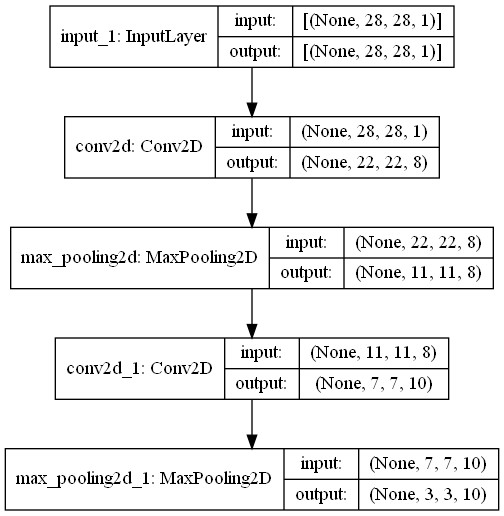

In [5]:
tf.keras.utils.plot_model(loc_net, to_file="layers/localisation_net.png", show_shapes=True, show_layer_names=True)

# Regressor for transformation parameters

In [6]:
affine_dense_layer = AffineDense()

In [7]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = LocalisationNet()(input_layer)
x = tf.reshape(input_layer, (-1, np.prod(x.shape[1:])))
x = affine_dense_layer.dense_1(x)
theta = affine_dense_layer.dense_2(x)
theta = tf.reshape(theta, (-1, 2, 3))
affine_dense = Model(inputs=input_layer,
                     outputs=theta)
affine_dense.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 90)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2912      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 2, 3)              0         
Total params: 3,110
Trainable params: 3,110
Non-trainable params: 0
_________________________________________________________________


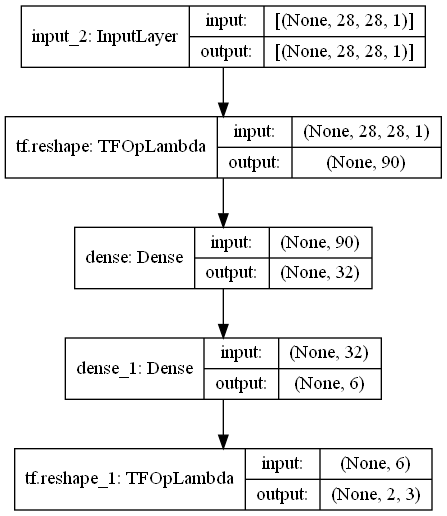

In [8]:
tf.keras.utils.plot_model(affine_dense, to_file="layers/affine_dense.png", show_shapes=True, show_layer_names=True)

# Parameterised Sampling Grid

In [9]:
sampling_grid_layer = SamplingGrid(IMG_SIZE, IMG_SIZE)

In [10]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = LocalisationNet()(input_layer)
theta = AffineDense()(x)
batch_grids = tf.matmul(theta, sampling_grid_layer.sampling_grid)
batch_grids = tf.reshape(batch_grids, (-1, 2, IMG_SIZE, IMG_SIZE))
sampling_grid = Model(inputs=input_layer,
                      outputs=batch_grids)
sampling_grid.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
localisation_net_2 (Localisa (None, 3, 3, 10)          2410      
_________________________________________________________________
affine_dense_1 (AffineDense) (None, 2, 3)              3110      
_________________________________________________________________
tf.linalg.matmul (TFOpLambda (None, 2, 784)            0         
_________________________________________________________________
tf.reshape_2 (TFOpLambda)    (None, 2, 28, 28)         0         
Total params: 5,520
Trainable params: 5,520
Non-trainable params: 0
_________________________________________________________________


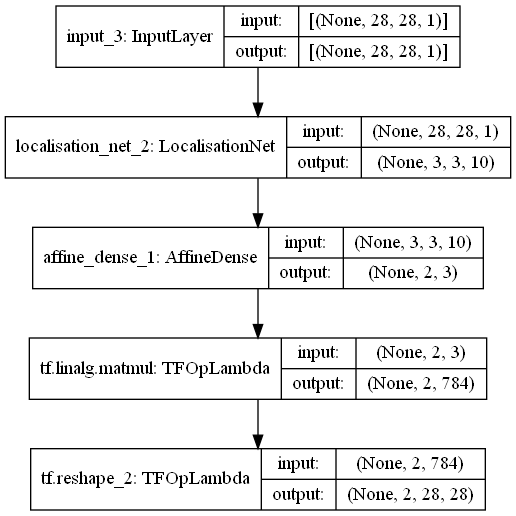

In [11]:
tf.keras.utils.plot_model(sampling_grid, to_file="layers/sampling_grid.png", show_shapes=True, show_layer_names=True)

# Spatial Transformer

In [12]:
spatial_transformer_layer = SpatialTransformer()

In [13]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = spatial_transformer_layer.loc_net(input_layer)
theta = spatial_transformer_layer.affine_dense(x)
grid = SamplingGrid(input_layer.shape[1], input_layer.shape[2])(theta)
x = spatial_transformer_layer.sampler([input_layer, grid])
spatial_transformer = Model(inputs=input_layer,
                            outputs=x)
spatial_transformer.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
localisation_net_3 (Localisatio (None, 3, 3, 10)     2410        input_4[0][0]                    
__________________________________________________________________________________________________
affine_dense_2 (AffineDense)    (None, 2, 3)         3110        localisation_net_3[0][0]         
__________________________________________________________________________________________________
sampling_grid_1 (SamplingGrid)  (None, 2, 28, 28)    0           affine_dense_2[0][0]             
____________________________________________________________________________________________

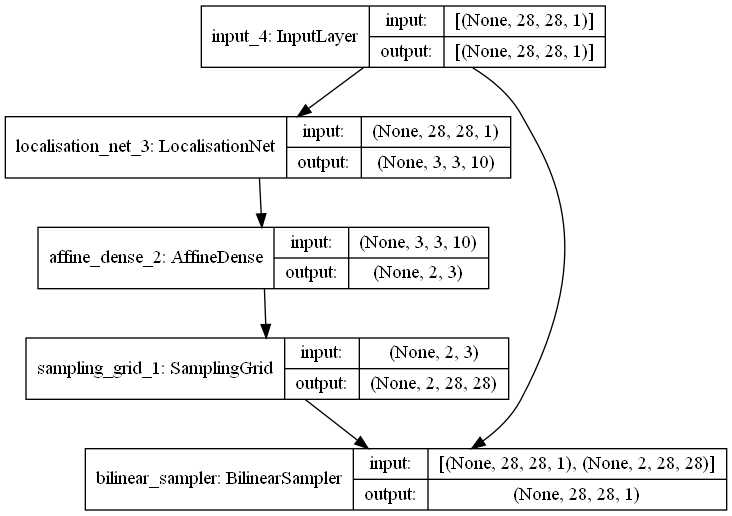

In [14]:
tf.keras.utils.plot_model(spatial_transformer, to_file="layers/spatial_transformer.png", show_shapes=True, show_layer_names=True)